In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import re
import warnings
import string
import emoji

# Ignore all future warnings
warnings.simplefilter(action='ignore')

# Importing data

In [2]:
english_major = pd.read_csv('database/english_major.csv')
english_major.shape

(43226, 25)

In [3]:
df = english_major[english_major.language == 'en']

In [4]:
df.shape

(42284, 25)

# Normalization

In [5]:
import string
import emoji

def normalization(text):
    text = emoji.replace_emoji(text, replace='')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Word Segmentation

In [6]:
from pyvi import ViTokenizer
import spacy

nlp = spacy.load('en_core_web_sm')
def word_segmentation(text,language):
    if language == 'vi':
        return ViTokenizer.tokenize(text)
    elif language == 'en':
        doc = nlp(text)
        return " ".join([token.text for token in doc])
    else:
        return text

In [7]:
df['input_comment'] = df['comment']
df['input_comment'] = df['input_comment'].apply(normalization)
df['input_comment'] = df['input_comment'].apply(lambda text: word_segmentation(text, 'en'))

Example:

In [22]:
# df.to_csv('df_input.csv', encoding = 'utf-8-sig',index=False)  # Set index=False to avoid writing row numbers

In [2]:
df = pd.read_csv('df_input.csv')

In [3]:
df['input_comment'].values[10]

'good close to airport swimming pool good breakfast only complaint could smell smoke from casino through air con in room large room sort of kiddy friendly with a naughty toddler breakfast was good something for everyone meals were nt too bad either only complaint hotel is in a boring location though cheaper easy enough to get taxi i booked it originally as its close to airport'

# LDA model using gensim

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import corpora

# df['input_comment'] = df['input_comment'].apply(normalization)
# df['input_comment'] = df['input_comment'].apply(lambda text: word_segmentation(text, 'vi'))

processed_texts = [doc.split(" ") for doc in df['input_comment'].astype(str).values.tolist()]
# print(processed_texts)

# Create a dictionary and a corpus using Gensim
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

## STOP WORDS

In [7]:
import stopwordsiso
stop_word_mul = stopwordsiso.stopwords(["en",'vi'])
# stop_word_en = stopwordsiso.stopwords(["en",'vi'])
# stop_word_mul = stopwordsiso.stopwords(["en",'vi'])


# print(stop_word_eng)

In [8]:
lda_model_gensim = gensim.models.ldamodel.LdaModel(corpus, num_topics=6, id2word=dictionary, passes=15)

# Display the topics
for idx, topic in lda_model_gensim.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")

Topic: 0 
Words: 0.073*"the" + 0.042*"is" + 0.042*"to" + 0.033*"and" + 0.029*"a" + 0.021*"hotel" + 0.021*"of" + 0.014*"in" + 0.013*"from" + 0.011*"are"
Topic: 1 
Words: 0.057*"to" + 0.035*"and" + 0.033*"staff" + 0.026*"they" + 0.018*"very" + 0.016*"help" + 0.015*"are" + 0.015*"you" + 0.014*"helpful" + 0.013*"us"
Topic: 2 
Words: 0.065*"the" + 0.024*"room" + 0.024*"was" + 0.022*"to" + 0.021*"and" + 0.020*"a" + 0.019*"not" + 0.016*"is" + 0.015*"but" + 0.014*"in"
Topic: 3 
Words: 0.073*"the" + 0.050*"we" + 0.049*"and" + 0.036*"was" + 0.034*"a" + 0.027*"to" + 0.022*"our" + 0.021*"were" + 0.016*"of" + 0.015*"in"
Topic: 4 
Words: 0.059*"i" + 0.031*"hotel" + 0.030*"to" + 0.029*"this" + 0.028*"the" + 0.024*"in" + 0.023*"stay" + 0.020*"my" + 0.020*"for" + 0.019*"you"
Topic: 5 
Words: 0.079*"and" + 0.046*"very" + 0.045*"staff" + 0.041*"good" + 0.037*"the" + 0.031*"is" + 0.031*"clean" + 0.030*"great" + 0.028*"location" + 0.027*"friendly"


In [10]:
import os
import pickle

def save_model(model, model_name):
    # Ensure the 'models' directory exists
    if not os.path.exists('models'):
        os.makedirs('models')
    # Define the full path for the model file
    file_path = os.path.join('models', model_name + '.pkl')
    # Save the model using pickle
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)


def load_model(model_name):
    # Define the full path for the model file
    file_path = os.path.join('models', model_name + '.pkl')
    # Load the model using pickle
    with open(file_path, 'rb') as file:
        model = pickle.load(file)
    return model

In [12]:
save_model(lda_model_gensim,'en_major_en_lda')

In [13]:
def remove_stopwords_from_topics(lda_model,stop_words):
    num_words = len(dictionary)
    topics = lda_model.show_topics(num_topics=-1, num_words=num_words, formatted=False)
    cleaned_topics = []
    
    for topic in topics:
        topic_id, word_probs = topic
        cleaned_words = [
            (word, prob) for word, prob in word_probs
            if word not in stop_words and not re.match(r'^\d+$', word)
        ]
        cleaned_topics.append((topic_id, cleaned_words))
    
    return cleaned_topics

In [14]:
new_topics = remove_stopwords_from_topics(lda_model_gensim,stop_word_mul)
for idx, topic in new_topics:
    print(f"Topic: {idx} \nWords: {topic[:10]}")

Topic: 0 
Words: [('hotel', 0.021315774), ('location', 0.010529681), ('walk', 0.009220656), ('beach', 0.008791526), ('walking', 0.0073003434), ('close', 0.0064848415), ('food', 0.0064663053), ('market', 0.0064100926), ('night', 0.006282695), ('street', 0.0062821615)]
Topic: 1 
Words: [('staff', 0.03270866), ('helpful', 0.014415998), ('friendly', 0.012870338), ('english', 0.012745024), ('service', 0.011897861), ('desk', 0.0106136175), ('staffs', 0.008346559), ('speak', 0.0071356012), ('manager', 0.0062318803), ('customer', 0.00589437)]
Topic: 2 
Words: [('nt', 0.007752816), ('hotel', 0.0064866976), ('water', 0.005865159), ('shower', 0.0044313245), ('n’t', 0.004330189), ('night', 0.00414401), ('bed', 0.0038668213), ('floor', 0.0035211507), ('bathroom', 0.0032364517), ('hot', 0.0028175716)]
Topic: 3 
Words: [('hotel', 0.010414895), ('staff', 0.009552007), ('stay', 0.0084771905), ('breakfast', 0.0058114394), ('stayed', 0.004464081), ('day', 0.0043857577), ('booked', 0.0030059656), ('amazin

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordCloud(topics,num_words = 10):

    num_topics = len(topics)
    # all_words = [(topic_id, word_probs[:num_words]) for topic_id, word_probs in topics]
    cols = 2  # Number of columns in the subplots grid
    rows = (num_topics + cols - 1) // cols  # Number of rows needed

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(13, 8))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D

    # word_freqs = {word: int(prob * 1000) for word, prob in all_words[topic_ids][1]}
    for i, (topic_id, word_probs) in enumerate(topics):
        # Calculate subplot position
        row = i // cols
        col = i % cols

        all_words = [(topic_id, word_probs[:num_words]) for topic_id, word_probs in topics]
        word_freqs = {word: int(prob * 1000) for word, prob in all_words[i][1]}
        
        # Generate the WordCloud for the current topic
        wordcloud = WordCloud(width=400, height=200, background_color='white', colormap = 'cividis').generate_from_frequencies(word_freqs)

        # Plot the WordCloud on the corresponding subplot
        ax = axes[i]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Topic {topic_id}')
        ax.axis('off')

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    # Adjust layout
    plt.tight_layout()
    plt.savefig('IMG/WC1.png')

    plt.show()

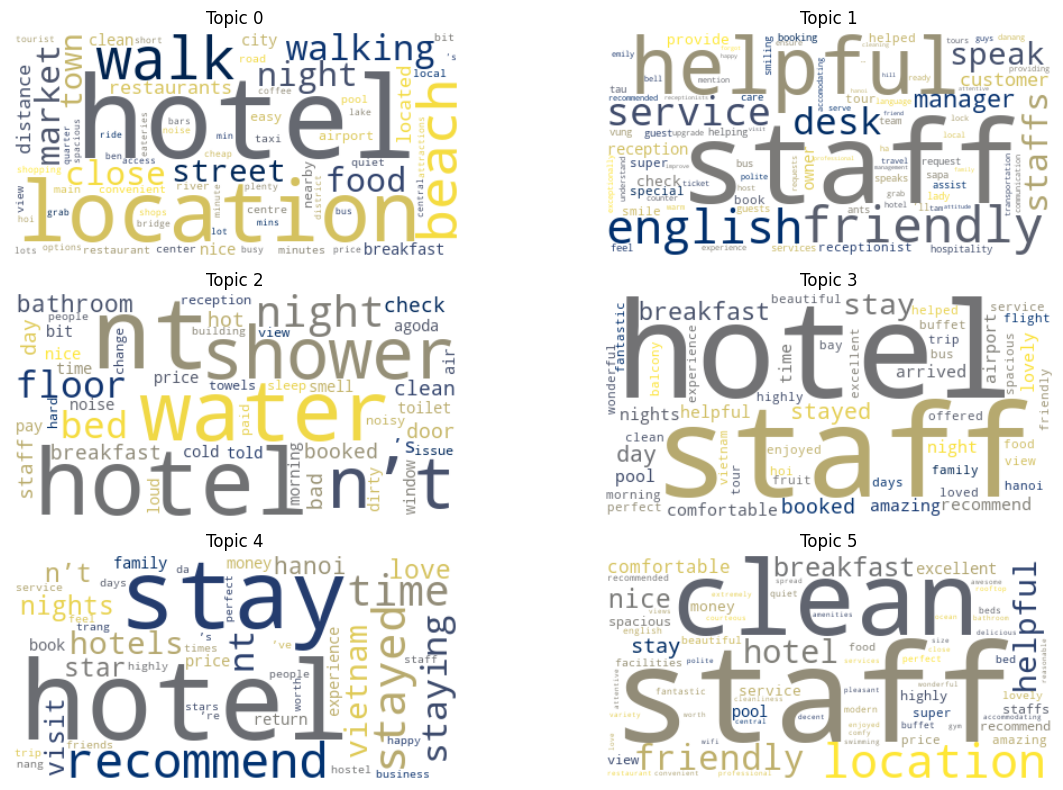

In [35]:
wordCloud(new_topics,100)

In [17]:
# english[(english['language'] == 'vi') & (english['national'] == 'Hoa Kỳ')]

# Scoring

In [18]:
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=lda_model_gensim, corpus=corpus, coherence='u_mass')
cm.get_coherence()

-1.1408803704218633

In [19]:
cm = CoherenceModel(model=lda_model_gensim, texts=processed_texts, coherence='c_v')
cm.get_coherence()

0.3957210705557752

In [20]:
results = []

lda_model_gensim = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)


for t in range(2, 10):
    lda_model_gensim = gensim.models.ldamodel.LdaModel(corpus, num_topics=t, id2word=dictionary, passes=15)

    corpus_lda = lda_model_gensim[corpus]

    cm = CoherenceModel(model=lda_model_gensim, corpus=corpus_lda, coherence='u_mass')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])


KeyboardInterrupt



In [ ]:
s = pd.Series(results.score.values, index=results.topic.values)
_ = s.plot()